In [1]:
import jax
jax.config.update('jax_enable_x64',True)
# jax.config.update("jax_default_device", jax.devices()[6])
import jax.numpy as jnp
import pandas as pd
from jax.random import PRNGKey as pkey
from jax.scipy.special import expit
from jaxopt import LBFGS
import statsmodels.api as sm
from tqdm.auto import tqdm
from functools import partial
from scipy.optimize import root_scalar,minimize_scalar

import numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from correlation_correction.methods import gl_methods as gl
from correlation_correction.methods import hamling_methods as ham
from correlation_correction.regressions import gls_reg, wls_reg

In [2]:
# Reading in data and removing trimmed point from model
study_df = pd.read_excel("../SBPvPAD_data.xlsx")
to_exclude = study_df.index.isin([4])
study_df = study_df[~to_exclude]
study_df.reset_index(inplace=True)
study_df = study_df.iloc[:,1:]

# Getting log odds ratios
study_df.iloc[0,5:8] = np.log(study_df.iloc[0,5:8].to_numpy().astype(np.float64))
study_df.iloc[4,5:8] = np.log(study_df.iloc[4,5:8].to_numpy().astype(np.float64))

# Get study specific data -- Hamling (and only Hamling) -- Stoekenbroek
L_s = study_df[study_df["Author"] == "Stoekenbroek"]["logOR"].to_numpy()[1:]
x_s = study_df[study_df["Author"] == "Stoekenbroek"]["dose"].to_numpy()[1:] - study_df["dose"][0]
v_s = (study_df[study_df["Author"] == "Stoekenbroek"]["std_error"].to_numpy()[1:])**2
N_s = study_df[study_df["Author"] == "Stoekenbroek"]["subjects"].to_numpy()
A_s_sum = study_df[study_df["Author"] == "Stoekenbroek"]["cases"].sum()
B_s_sum = study_df[study_df["Author"] == "Stoekenbroek"]["controls"].sum()
b0_s = study_df[study_df["Author"] == "Stoekenbroek"]["controls"][0]
p_s = b0_s / B_s_sum
z_s = B_s_sum / A_s_sum

# Get study specific data -- Hamling (and only Hamling) -- Itoga
L_i = study_df[study_df["Author"] == "Itoga"]["logOR"].to_numpy()[1:]
x_i = study_df[study_df["Author"] == "Itoga"]["dose"].to_numpy()[1:] - study_df["dose"][4]
v_i = (study_df[study_df["Author"] == "Itoga"]["std_error"].to_numpy()[1:])**2
N_i = study_df[study_df["Author"] == "Itoga"]["subjects"].to_numpy()
A_i_sum = study_df[study_df["Author"] == "Itoga"]["cases"].sum()
B_i_sum = study_df[study_df["Author"] == "Itoga"]["controls"].sum()
b0_i = study_df[study_df["Author"] == "Itoga"]["controls"][4]
p_i = b0_i / B_i_sum
z_i = B_i_sum / A_i_sum

# Get odds ratios and exposures for each study
L = np.hstack((L_s, L_i))
x = np.hstack((x_s, x_i))
v = np.hstack((v_s,v_i))


In [3]:
# Get counts from Hamling method for both studies
counts_s = ham.hamling(L_s,p_s,z_s,v_s)
counts_i = ham.hamling(L_i,p_i,z_i,v_i)

# Get covariance matrices from both studies
C_s = counts_s.cov(v_s)
C_i = counts_i.cov(v_i)

# Get block diagonal matrix of covariances
C = block_diag(C_s, C_i)

In [4]:
np.linalg.eigvalsh(C_i)

array([-0.00057268, -0.00012103,  0.00034121,  0.00690497])

In [5]:
# Get counts from Hamling method for both studies
counts_s = gl.convex_gl(L_s,N_s,A_s_sum)
counts_i = gl.convex_gl(L_i,N_i,A_i_sum)

# Get covariance matrices from both studies
C_s = counts_s.cov(v_s)
C_i = counts_i.cov(v_i)

# Get block diagonal matrix of covariances
C = block_diag(C_s, C_i)

In [6]:
np.linalg.eigvalsh(C_i)

array([0.00033416, 0.00041533, 0.00060387, 0.00519911])

In [7]:
counts_s.A

array([49.00858886, 50.48732251, 94.87557861])

In [8]:
# Perfrom generalized regression
b_star, v_star = gls_reg(C,L,x)

# Perfrom regression weighted by reported variances
b, v = wls_reg(L,x,v)

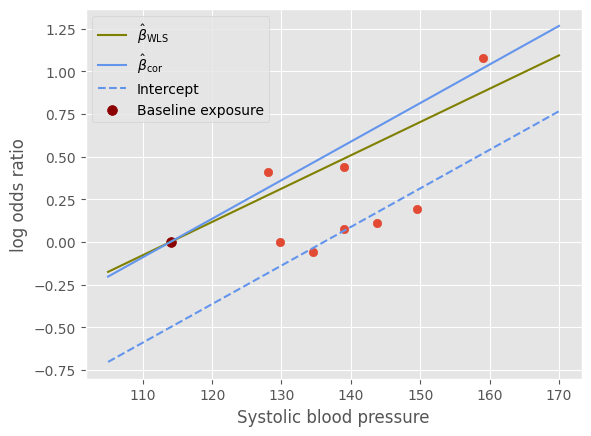

In [9]:
# Perform plot
def slope_fn(beta,x):
    return beta*(x-114)

xs = np.linspace(105,170)

# plt.plot(x,slope_fn(beta_s,x),label="No weights--S",c="olive")
# # plt.fill_between(x,slope_fn(low_beta_s,x),slope_fn(high_beta_s,x),alpha=0.3,color="olive")
# plt.plot(x,slope_fn(beta_s_GL,x),label="Weights--S",c="cornflowerblue")
# plt.fill_between(x,slope_fn(low_beta_s_GL,x),slope_fn(high_beta_s_GL,x),alpha=0.3,color="cornflowerblue")
plt.plot(xs,slope_fn(b,xs),label=r"$\hat \beta_{\mathrm{WLS}}$",c="olive")
plt.plot(xs,slope_fn(b_star,xs),label=r"$\hat \beta_{\mathrm{cor}}$",c="cornflowerblue")
plt.plot(xs,slope_fn(b_star,xs)-0.5,label="Intercept",linestyle="dashed",c="cornflowerblue")
plt.scatter(study_df["dose"],study_df["logOR"])
plt.scatter(114.,0,c="darkred",s=50,label="Baseline exposure")
plt.ylabel("log odds ratio")
plt.xlabel("Systolic blood pressure")
plt.legend()
# plt.savefig("images/itoga_regression.pdf",bbox_inches="tight",pad_inches=0.1)
plt.show()

#### Gamma estimation

In [10]:
logdet = jax.jit(lambda x:jnp.linalg.slogdet(x)[1])

#@jax.jit
def margin_like(gamma,covariance_matrices,Y,X_vals,Z_vals):
    vmats = [Z@Z.T*gamma + C for C,Z in zip(covariance_matrices,Z_vals)]
    inv_vmats = [jnp.linalg.inv(V) for V in vmats]
    LNV = jnp.sum(jnp.array([logdet(V) for V in vmats]))
    beta = (
        jnp.linalg.inv(jnp.sum(jnp.array([X.T@inv_V@X for inv_V,X in zip(inv_vmats,X_vals)]),axis=0))@ 
        (jnp.sum(jnp.array([X.T@inv_V@y for inv_V,y,X in zip(inv_vmats,Y,X_vals)]),axis=0))
    )
    res_term = jnp.sum(
        jnp.array([
            (X@beta - y).T@inv_v@(X@beta-y) 
            for inv_v,y,X in zip(inv_vmats,Y,X_vals)])
        )
    return LNV+res_term


# @jax.jit
# def margin_like_reml(gamma,covariance_matrices,Y,X,Z):
#     ZZT = Z@Z.T
#     vmats = jnp.array([ZZT*gamma + C for C in covariance_matrices])
#     inv_vmats = jnp.array([jnp.linalg.inv(V) for V in vmats])
#     LNV = jnp.sum(jnp.array([logdet(V) for V in vmats]))
#     REML_term = jnp.log(jnp.sum(jnp.array([X.T@invV@X for invV in inv_vmats])))
#     beta = (
#         jnp.linalg.inv(jnp.sum(jnp.array([X.T@inv_V@X for inv_V in inv_vmats]),axis=0))@ 
#         (jnp.sum(jnp.array([X.T@inv_V@y for inv_V,y in zip(inv_vmats,Y)]),axis=0))
#     )
#     res_term = jnp.sum(
#         jnp.array([
#             (X@beta - y).T@inv_v@(X@beta-y) 
#             for inv_v,y in zip(inv_vmats,Y)])
#         )
#     return LNV + res_term + REML_term
# vec_reml_like = (
#     jax.vmap(margin_like_reml,in_axes=[0,None,None,None,None])
# )
# diff_reml_like = jax.jit(
#     jax.grad(margin_like_reml,argnums=0)
# )
# diff_margin_like = jax.jit(
#     jax.grad(margin_like,argnums=0)
# )
vec_margin_like = (
    jax.vmap(margin_like,in_axes=[0,None,None,None,None])
)


# def estimate_gamma(L_vals,cov_mats,X_vals,Z_vals):
#     gamma_grid = jnp.logspace(-4,2,20)
#     try:
#         gamma = root_scalar(lambda x:diff_margin_like(x,cov_mats,L_vals,X_vals,Z_vals),bracket = (1e-3,10.)).root
#     except:
#         nll = vec_margin_like(gamma_grid,cov_mats,L_vals,X_vals,Z_vals)
#         gamma = gamma_grid[jnp.argmin(nll)]

#     vmats = jnp.array([Z@Z.T*gamma + C for C,Z in zip(cov_mats,Z_vals)])
#     inv_vmats = jnp.array([jnp.linalg.inv(V) for V in vmats])
#     beta = (
#         jnp.linalg.inv(jnp.sum(jnp.array([X.T@inv_V@X for inv_V,X in zip(inv_vmats,X_vals)]),axis=0))@ 
#         (jnp.sum(jnp.array([X.T@inv_V@y for inv_V,y,X in zip(inv_vmats,Y,X_vals)]),axis=0))
#     )
#     return jnp.array(gamma),beta[0]

In [11]:
X = x.reshape(-1,1)
Z = x.reshape(-1,1)


X_vals = [X[:3],X[3:]]
Z_vals = [Z[:3],Z[3:]]
covmats = [C_s,C_i]
L_vals = [L_s,L_i]

#gamma, beta = estimate_gamma(L_vals, covmats, X_vals, Z_vals)

In [12]:
Z

array([[14. ],
       [25. ],
       [45. ],
       [ 4.8],
       [ 9.2],
       [13.9],
       [19.7]])

In [21]:
C = jax.scipy.linalg.block_diag(C_s,C_i)

def margin_like_reml(gamma,cov,Y,X,Z):
    outer_piece = jax.scipy.linalg.block_diag(Z[:3]@Z[:3].T,Z[3:]@Z[3:].T)
    V = outer_piece* gamma + cov
    inv_V = jnp.linalg.inv(V)
    LNV = logdet(V)
    REML_term = logdet(X.T@inv_V@X)
    beta = jnp.linalg.inv(X.T@inv_V@X)@X.T@inv_V@Y
    res_term = (X@beta - Y).T@inv_V@(X@beta-Y)
    return LNV + res_term + REML_term

vec_reml = (
    jax.vmap(margin_like_reml,in_axes=[0,None,None,None,None])
)


Correlated:  5.478901179593945e-05
Diagonal:  0.00012603829296797275


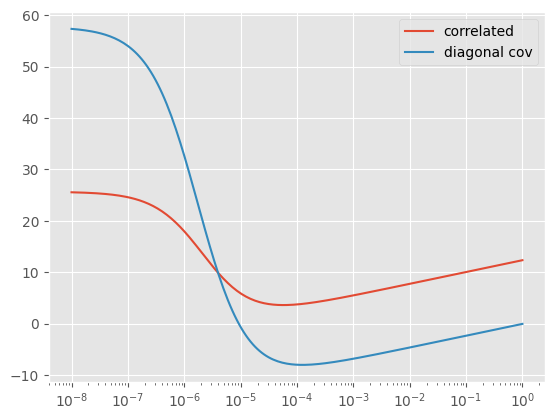

In [24]:
gamma_grid = jnp.logspace(-8,0,200)
nll = vec_reml(gamma_grid,C,L,X,Z)


Cdiag = jnp.diag(jnp.diag(C))
nll_diag = vec_reml(gamma_grid,Cdiag,L,X,Z)


gamma = gamma_grid[jnp.argmin(nll)]
gamma_diag = gamma_grid[jnp.argmin(nll_diag)]
print("Correlated: ",gamma)
print("Diagonal: ",gamma_diag)
plt.plot(gamma_grid,nll,label = 'correlated')
plt.plot(gamma_grid,nll_diag,label = 'diagonal cov')
plt.xscale('log')
plt.legend()
plt.show()


In [25]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

groups = jnp.array([0,0,0.,1,1,1,1.])

df = pd.DataFrame({
    'L':L,
    "group":groups,
    'X':x
})

md = smf.mixedlm("L ~ 0 + X", df, groups=df['group'],re_formula = '~ 0 + X')

mdf = md.fit()
print(mdf.summary())


       Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: L     
No. Observations: 7       Method:             REML  
No. Groups:       2       Scale:              0.0065
Min. group size:  3       Log-Likelihood:     inf   
Max. group size:  4       Converged:          Yes   
Mean group size:  3.5                               
------------------------------------------------------
        Coef.   Std.Err.   z   P>|z|   [0.025   0.975]
------------------------------------------------------
X       0.028                                         
X Var   0.000                                         



/home/owlx/miniconda3/envs/corr_correct/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/owlx/miniconda3/envs/corr_correct/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/owlx/miniconda3/envs/corr_correct/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/owlx/miniconda3/envs/corr_correct/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/owlx/miniconda3/envs/corr_correct/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The 